# Part 1: A simple example: Object recognition using regional properties:

Let's start with an image with circles and triangles of different sizes:

## 1. Generation of the sample image:

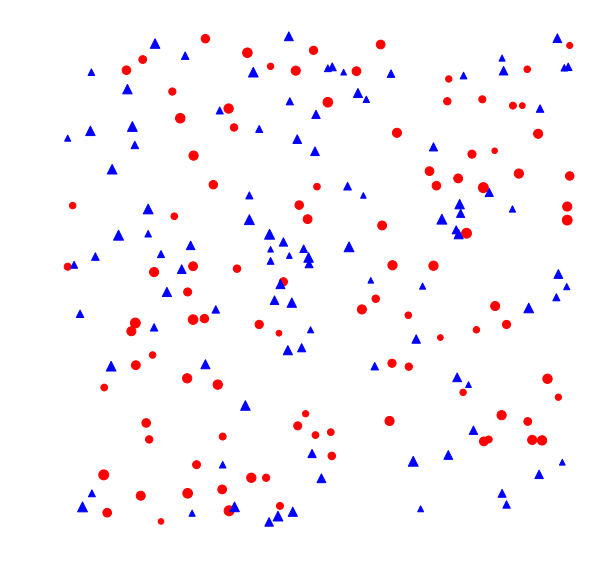

In [2]:
import numpy as np 
np.random.seed(13)

import matplotlib.pyplot as plt 
Isize = 1024
N = 100

X = np.random.randint(Isize, size=(2,2*N)) # random placement of objects

fig = plt.figure(figsize=(10,10))
symsizes1 = np.random.randint(30,100,size=(2,N))
symsizes2 = np.random.randint(30,100,size=(2,N))
plt.scatter(X[0,0:N-1], X[1,0:N-1], s=symsizes1, c='r',edgecolor="red",marker = 'o')
plt.scatter(X[0,N:2*N], X[1,N:2*N], s=symsizes2, c='b',edgecolor="blue",marker = '^')
plt.axis('off')
plt.savefig('Patterns.png',dpi=600, facecolor='w',optimize=False,bbox_inches='tight')
plt.show()

## Reading the image:

In [ ]:
import matplotlib.pyplot as plt
import skimage as sk 

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label

I = sk.io.imread('Patterns.png',as_gray=True) # read image as grayscale (no color information)
IC = sk.io.imread('Patterns.png') # read image as color (to define object class labels: triangle, circle)

fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Grayscale image') 
ax[1].imshow(IC,cmap=plt.cm.jet)
ax[1].set_title('Color image') # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

## 2. Segmentation and regional features:

We now segment and extract regional properties:

In [ ]:
bw = np.logical_not(I==1)# Set regions white and background black
# label image regions:
label_image, nregions = label(bw,return_num=True)

# Segmentation figure:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(bw,cmap=plt.cm.gray)
ax[0].set_title('Original image') 
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

# Get regional properties:
from skimage.measure import regionprops
props = regionprops(label_image)

# Get relevant features (eccentricity and area, for instance)
features = np.zeros((nregions,2))
labels = np.zeros(nregions)
# Save class label of each object (1: triangle, 2:circle)
bw1 = np.array(IC[:,:,0]==0,dtype=np.uint8)
bw2 = np.array(IC[:,:,2]==0,dtype=np.uint8)
for i in range(0,nregions):
    features[i,0] = props[i].eccentricity
    features[i,1] = props[i].area
    labels[i] = bw1[np.int(props[i].centroid[0]),np.int(props[i].centroid[1])]+2*bw2[np.int(props[i].centroid[0]),np.int(props[i].centroid[1])]

## 3. Analysis of features:

A scatterplot of features shows that circles present low eccentricity whereas triangles present eccentricity around 0.5. There are some observations with higher eccentricities due to the overlaping cases between triangles and circles. 

In [ ]:
fig = plt.figure(figsize=(14,10))
plt.scatter(features[:,0], features[:,1], s=30, c=labels,marker = 'o')
plt.xlabel('Eccentricity')
plt.ylabel('Area')
plt.show()

## 4. Fit Linear Discriminant Analysis (LDA):

Using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations. Fit a LDA classifier using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

NTRAIN = 50 # Train with NTRAIN objects

clf = LinearDiscriminantAnalysis()
clf.fit(features[0:NTRAIN,:], labels[0:NTRAIN])

Evaluate performance using Test dataset:

In [ ]:
labels_pred = clf.predict(features[NTRAIN+1:-1])
labels_true = labels[NTRAIN+1:-1]

In [ ]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(labels_true,labels_pred)
CM

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels_true,labels_pred))

# Part 2: Face segmentation using PCA features:

We need a labelled face recognition database in which each image has a class label identifying the person to which it corresponds. In this case we are not classifying objects (regions of the image) but the whole image itself. We are going to use the Principal Component Analysis (PCA) of the pixels in the image as features of the whole image instead regional properties as in the previous example. PCA is a dimensionality reduction method that reduces the number of variables needed to describe the images (before PCA, we use as many variables as pixels in the image, after PCA we have a reduced number of variables that are a weighted linear combination of the original pixels in the image). 

Let's get started: 

## 1. Read images from dataset:

In this example we are going to use the image dataset 'Labelled Faces in the Wild' http://vis-www.cs.umass.edu/lfw/
that contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured (famous people).

In [ ]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print('Width {} pixels'.format(w))
print('Height {} pixels'.format(h))

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

## 2. Feature Extraction: PCA features (eigenfaces)

In [ ]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("PCA projection of the images")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


## 3. Fit different unsupervised classifiers:

### Support Vector Machine (SVM):

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm = svm.fit(X_train_pca, y_train)

Performance Evaluation (using test images):

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
y_pred_svm = svm.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print(confusion_matrix(y_test, y_pred_svm, labels=range(n_classes)))

### Linear Discriminant Analysis (LDA):

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train)
y_pred_lda = lda.predict(X_test_pca)
print(classification_report(y_test, y_pred_lda, target_names=target_names))
print(confusion_matrix(y_test, y_pred_lda, labels=range(n_classes)))

### Decision Trees:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt = dt.fit(X_train_pca, y_train)
y_pred_dt = dt.predict(X_test_pca)
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print(confusion_matrix(y_test, y_pred_dt, labels=range(n_classes)))


### Artificial Neural Networks (ANNs):

In [ ]:
from sklearn.neural_network import MLPClassifier
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,), random_state=1)
ann.fit(X_train_pca, y_train)
y_pred_ann = ann.predict(X_test_pca)
print(classification_report(y_test, y_pred_ann, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ann, labels=range(n_classes)))

# Part 3: Deep Learning: Convolutional Neural Networks

We are going to use the image database for handwritten digits MNIST: http://yann.lecun.com/exdb/mnist/

The database has a training set of 60,000 images of digits, and a test set of 10,000 examples.

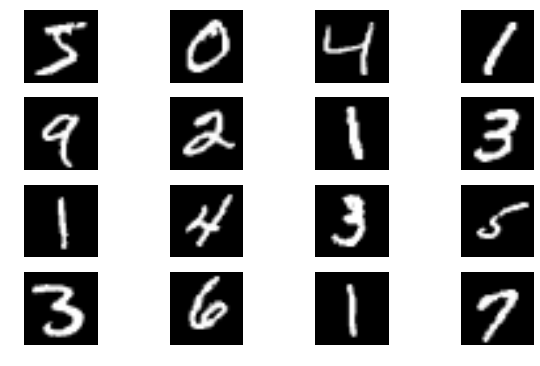


In [526]:
# Cargar la base de datos MNIST y librerias Keras:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# Establecer la semilla del generador de numeros aleatorios para garantizar reproducibilidad de los resultados 
seed = 7
numpy.random.seed(seed)

# Acceder a las imagenes de entrenamiento y test
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Dimensionar las imagenes en vectores 
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# Normalizar las imagenes de escala de grises 0-255 (valores entre 0-1):
X_train = X_train / 255
X_test = X_test / 255

# Codificar las etiquetas de clase en formato de vectores categoricos con diez posiciones: 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

# Funcion en la que se define la arquitectura del modelo:
def baseline_model():
# Capa de entrada:
	model = Sequential() 
# Primera capa (Convolucional):
	model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu')) 	
# Tercera capa (agrupamiento):
	model.add(MaxPooling2D(pool_size=(2, 2))) 
# Cuarta capa (regularizacion)
	model.add(Dropout(0.2))
# Quinta capa (redimensionamiento): 
	model.add(Flatten())
# Sexta capa (completamente conectada)
	model.add(Dense(128, activation='relu')) 
# Capa de salida (softmax):
	model.add(Dense(num_classes, activation='softmax')) 
# Compilar el modelo y especificar metodo y metrica de optimizacion:
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# Llamada al modelo: 
model = baseline_model()

# Ajustar el modelo utilizando los datos de entrenamiento y validacion con los de test:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=200, verbose=2)

# Evaluacion del modelo utilizando los datos de test:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Exactitud del modelo: %.2f%%" % (100*scores[1]))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
 - 91s - loss: 0.2229 - acc: 0.9366 - val_loss: 0.0797 - val_acc: 0.9750
Epoch 2/3
 - 84s - loss: 0.0713 - acc: 0.9787 - val_loss: 0.0450 - val_acc: 0.9851
Epoch 3/3
 - 82s - loss: 0.0512 - acc: 0.9841 - val_loss: 0.0447 - val_acc: 0.9856
Exactitud del modelo: 98.56%


In [529]:
y_pred_cnn = model.predict(X_test)
y_pred_cnn = np.argmax(y_pred_cnn,axis=1) # convert categorical labels to integer labels
y_test1 = np.argmax(y_test,axis=1) # convert categorical labels to integer labels
print(classification_report(y_test1, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.96      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

